In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes_masked

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-21 11:49:52.835837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


In [2]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [3]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [4]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [5]:
ID = 191
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])
for i in range(data.shape[0]):
    data[i, :, :, :] = 2.0*(data[i, :, :, :] - mins[i])/(maxs[i]-mins[i]) - 1.0

In [6]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']
obs_mask = dataset['obs_mask']

In [7]:
layers = [3, 64, 64, 64, 64, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = Circuit2_variant5716(dtype=tf.float64, D_A=df_params.d_A[ID], D_B = df_params.d_B[ID])
model = TINN_multi_nodes_masked(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                alpha = 0.5, 
                print_precision=".8f")

In [8]:
results = model.train(epochs = 50,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.76710433
total loss: 5.91475241, total regularisd loss (sum of batches): 15596.14976807
obs A loss: 0.81311505, pde A loss: 0.35111554
obs B loss: 0.51868856, pde B loss: 0.13023827
obs C loss: 1.71253419, pde C loss: 0.39377061
obs D loss: 0.47136367, pde D loss: 0.12738674
obs E loss: 0.62166377, pde E loss: 0.16476405
obs F loss: 0.46526020, pde F loss: 0.14485178
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 9.47191 b_B: 9.19557 b_C: 9.13694 b_D: 9.36411 
b_E: 9.25090 b_F: 9.36508 V_A: 9.47511 V_B: 8.93412 
V_C: 9.14082 V_D: 9.22695 V_E: 8.98776 V_F: 9.14562 
k_AA: 11.00457 k_BD: 10.80228 k_CE: 9.34664 k_DA: 8.67528 
k_EB: 9.17506 k_EE: 10.95023 k_FE: 9.55921 mu_A:

Training observations acc over epoch: 0.07186015
total loss: 0.45640944, total regularisd loss (sum of batches): 1203.51509274
obs A loss: 0.01519205, pde A loss: 0.00216359
obs B loss: 0.04705306, pde B loss: 0.00420908
obs C loss: 0.15224631, pde C loss: 0.00452638
obs D loss: 0.06808886, pde D loss: 0.00521718
obs E loss: 0.08341044, pde E loss: 0.00432841
obs F loss: 0.06517005, pde F loss: 0.00480402
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 1.12986 b_B: 0.00000 b_C: 0.00000 b_D: 2.10209 
b_E: 0.00000 b_F: 1.48454 V_A: 5.02149 V_B: 4.53137 
V_C: 2.88364 V_D: 5.74289 V_E: 4.06513 V_F: 5.22103 
k_AA: 14.58613 k_BD: 14.33982 k_CE: 7.68099 k_DA: 0.00000 
k_EB: 7.33338 k_EE: 15.01847 k_FE: 8.18348 mu_A: 17.40216 
mulv_A: 

Training observations acc over epoch: 0.06416693
total loss: 0.40698180, total regularisd loss (sum of batches): 1073.21926222
obs A loss: 0.01065408, pde A loss: 0.00198452
obs B loss: 0.04136676, pde B loss: 0.00346045
obs C loss: 0.14557929, pde C loss: 0.00482980
obs D loss: 0.05599195, pde D loss: 0.00352029
obs E loss: 0.07821644, pde E loss: 0.00391196
obs F loss: 0.05319308, pde F loss: 0.00427319
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.00000 b_D: 0.26885 
b_E: 0.00000 b_F: 0.00000 V_A: 4.95688 V_B: 3.94931 
V_C: 2.81863 V_D: 3.44872 V_E: 1.66312 V_F: 2.83388 
k_AA: 15.13095 k_BD: 16.69053 k_CE: 7.12242 k_DA: 0.00000 
k_EB: 7.29159 k_EE: 17.24077 k_FE: 7.67945 mu_A: 13.14239 
mulv_A: 

Training observations acc over epoch: 0.06491303
total loss: 0.50313069, total regularisd loss (sum of batches): 1326.72472126
obs A loss: 0.01112043, pde A loss: 0.00624090
obs B loss: 0.04059194, pde B loss: 0.00239092
obs C loss: 0.14617140, pde C loss: 0.00571566
obs D loss: 0.05818688, pde D loss: 0.09065855
obs E loss: 0.07882836, pde E loss: 0.00449192
obs F loss: 0.05457927, pde F loss: 0.00415446
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.00000 b_D: 0.00004 
b_E: 0.00000 b_F: 0.00000 V_A: 4.81281 V_B: 3.07068 
V_C: 2.67281 V_D: 0.69764 V_E: 0.00000 V_F: 0.00000 
k_AA: 15.93817 k_BD: 19.08478 k_CE: 6.94164 k_DA: 0.00000 
k_EB: 7.18205 k_EE: 18.34408 k_FE: 7.52616 mu_A: 7.24363 
mulv_A: 1

Training observations acc over epoch: 0.05899462
total loss: 0.98053404, total regularisd loss (sum of batches): 2585.49513583
obs A loss: 0.00743923, pde A loss: 0.00218738
obs B loss: 0.02381394, pde B loss: 0.00008147
obs C loss: 0.14060317, pde C loss: 0.00526728
obs D loss: 0.05889412, pde D loss: 0.61128976
obs E loss: 0.07343758, pde E loss: 0.00396798
obs F loss: 0.04977969, pde F loss: 0.00377244
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00099 b_C: 0.00000 b_D: 0.00143 
b_E: 0.00000 b_F: 0.00000 V_A: 4.75980 V_B: 0.52531 
V_C: 2.61782 V_D: 0.00000 V_E: 0.00010 V_F: 0.00000 
k_AA: 17.27966 k_BD: 19.39216 k_CE: 6.94164 k_DA: 0.00000 
k_EB: 7.17020 k_EE: 18.34408 k_FE: 7.52616 mu_A: 0.00000 
mulv_A: 1

Training observations acc over epoch: 0.04847238
total loss: 0.32117058, total regularisd loss (sum of batches): 846.92619926
obs A loss: 0.00657454, pde A loss: 0.00075952
obs B loss: 0.01997534, pde B loss: 0.00023837
obs C loss: 0.12170148, pde C loss: 0.00889755
obs D loss: 0.04082774, pde D loss: 0.01283343
obs E loss: 0.06192715, pde E loss: 0.00437117
obs F loss: 0.03982789, pde F loss: 0.00323640
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00052 b_C: 0.00000 b_D: 0.00082 
b_E: 0.00000 b_F: 0.00582 V_A: 4.75960 V_B: 0.00011 
V_C: 2.61448 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30437 k_BD: 19.39518 k_CE: 6.94164 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 18.34411 k_FE: 7.52616 mu_A: 0.04625 
mulv_A: 4.

Training observations acc over epoch: 0.01548816
total loss: 0.09516714, total regularisd loss (sum of batches): 250.95515056
obs A loss: 0.00596827, pde A loss: 0.00063172
obs B loss: 0.01379167, pde B loss: 0.00046517
obs C loss: 0.00225528, pde C loss: 0.00002001
obs D loss: 0.02279223, pde D loss: 0.00040879
obs E loss: 0.02542469, pde E loss: 0.00031023
obs F loss: 0.02269681, pde F loss: 0.00040226
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.01475 b_C: 0.00000 b_D: 0.01001 
b_E: 0.00000 b_F: 0.00997 V_A: 4.68107 V_B: 0.00057 
V_C: 2.54182 V_D: 8.39074 V_E: 4.94053 V_F: 8.37372 
k_AA: 17.30441 k_BD: 7.93669 k_CE: 7.84366 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 12.97652 k_FE: 9.07839 mu_A: 0.00000 
mulv_A: 0.0

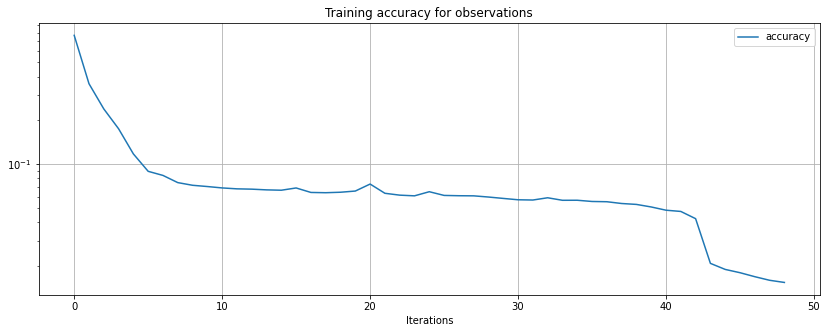

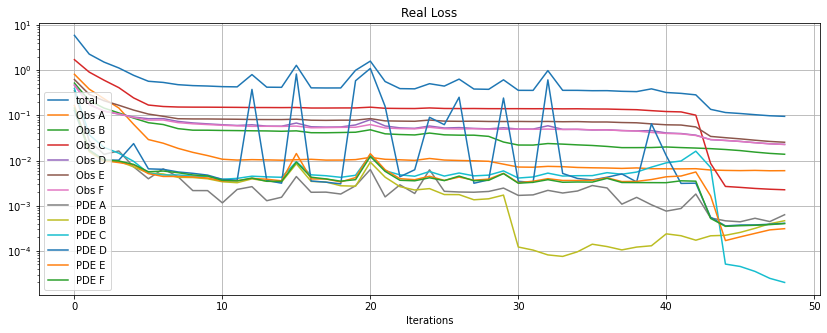

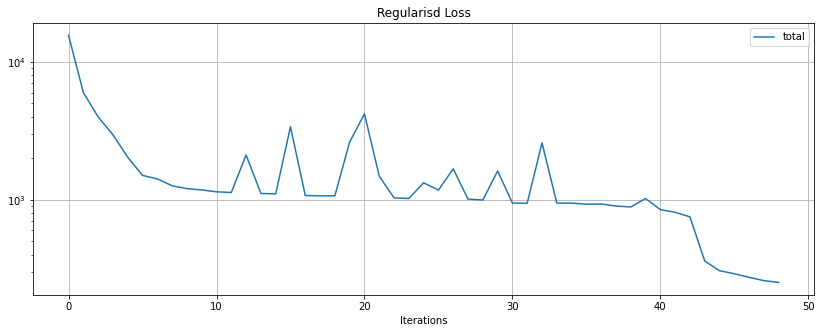

In [21]:
plot_result(merge_dict(results), node_names=node_names, start = 0)#, yscale='linear')

In [19]:
results2 = model.train(epochs = 10,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.01548307
total loss: 0.09526467, total regularisd loss (sum of batches): 251.21413048
obs A loss: 0.00595144, pde A loss: 0.00061284
obs B loss: 0.01361587, pde B loss: 0.00052917
obs C loss: 0.00220350, pde C loss: 0.00002097
obs D loss: 0.02394401, pde D loss: 0.00045211
obs E loss: 0.02491015, pde E loss: 0.00032030
obs F loss: 0.02227347, pde F loss: 0.00043084
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.01678 b_C: 0.00000 b_D: 0.01649 
b_E: 0.00000 b_F: 0.01607 V_A: 4.65046 V_B: 0.00000 
V_C: 2.51150 V_D: 8.09468 V_E: 4.89457 V_F: 8.10369 
k_AA: 17.30442 k_BD: 8.18845 k_CE: 7.76179 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 13.02816 k_FE: 9.76049 mu_A: 0.

Training observations acc over epoch: 0.01458103
total loss: 0.08998779, total regularisd loss (sum of batches): 237.29601644
obs A loss: 0.00630835, pde A loss: 0.00087934
obs B loss: 0.01297685, pde B loss: 0.00053866
obs C loss: 0.00211569, pde C loss: 0.00001693
obs D loss: 0.02141898, pde D loss: 0.00038936
obs E loss: 0.02366023, pde E loss: 0.00028765
obs F loss: 0.02100609, pde F loss: 0.00038966
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.01890 b_C: 0.00000 b_D: 0.01295 
b_E: 0.00000 b_F: 0.01286 V_A: 4.59340 V_B: 0.00000 
V_C: 2.45778 V_D: 7.99890 V_E: 4.24624 V_F: 7.47580 
k_AA: 17.30447 k_BD: 8.20804 k_CE: 7.25586 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 13.64310 k_FE: 11.29505 mu_A: 0.00000 
mulv_A: 0.

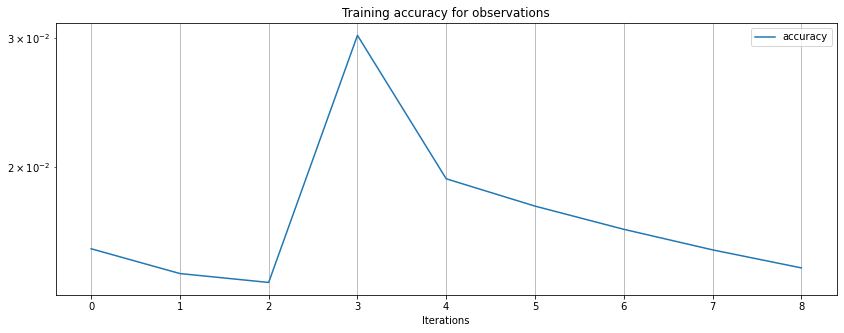

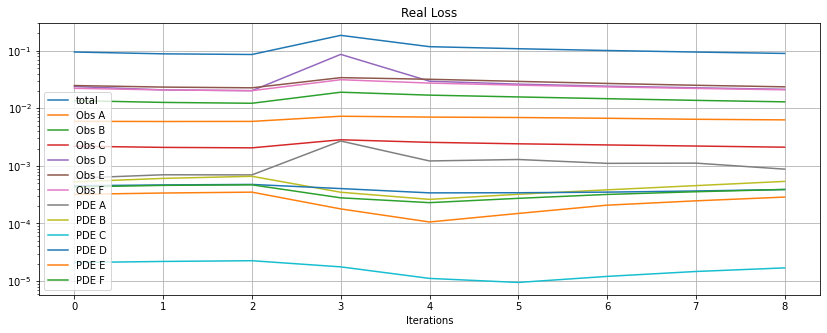

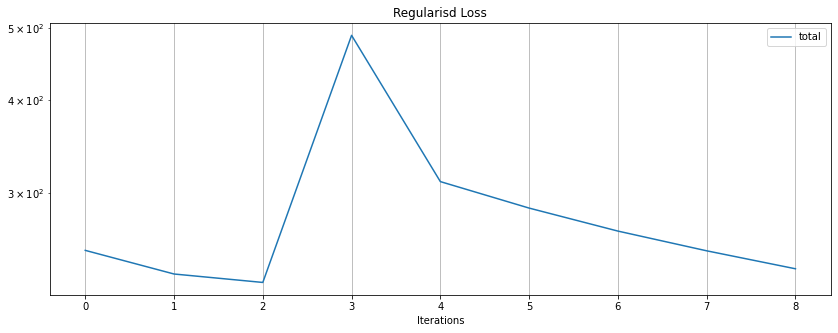

In [22]:
plot_result(results2, node_names=node_names, start = 0)

In [25]:
results3 = model.train(epochs = 10,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.01340074
total loss: 0.08309344, total regularisd loss (sum of batches): 219.11867979
obs A loss: 0.00613540, pde A loss: 0.00076981
obs B loss: 0.01183724, pde B loss: 0.00067700
obs C loss: 0.00198753, pde C loss: 0.00002055
obs D loss: 0.01948173, pde D loss: 0.00043568
obs E loss: 0.02164255, pde E loss: 0.00034653
obs F loss: 0.01931996, pde F loss: 0.00043945
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.01620 b_C: 0.00000 b_D: 0.01222 
b_E: 0.00000 b_F: 0.01278 V_A: 4.54628 V_B: 0.00030 
V_C: 2.41295 V_D: 7.40285 V_E: 3.88931 V_F: 6.81226 
k_AA: 17.30451 k_BD: 8.80402 k_CE: 6.99088 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 13.98534 k_FE: 11.58878 mu_A: 0

Training observations acc over epoch: 0.01029560
total loss: 0.07612393, total regularisd loss (sum of batches): 419.60958784
obs A loss: 0.00584092, pde A loss: 0.00992847
obs B loss: 0.00909852, pde B loss: 0.00218592
obs C loss: 0.00166213, pde C loss: 0.00014827
obs D loss: 0.01453020, pde D loss: 0.00072197
obs E loss: 0.01622328, pde E loss: 0.00063422
obs F loss: 0.01441860, pde F loss: 0.00073144
lambda obs A: 0.69601480, lambda pde A: 0.02684221
lambda obs B: 1.55430846, lambda pde B: 0.21268304
lambda obs C: 0.11659568, lambda pde C: 0.00417056
lambda obs D: 2.69485051, lambda pde D: 0.08530742
lambda obs E: 3.56029857, lambda pde E: 0.06056914
lambda obs F: 2.90385194, lambda pde F: 0.08450766
b_A: 0.00000 b_B: 0.01729 b_C: 0.00000 b_D: 0.02094 
b_E: 0.00000 b_F: 0.02110 V_A: 4.40142 V_B: 0.00019 
V_C: 2.28492 V_D: 2.90211 V_E: 0.00000 V_F: 2.80255 
k_AA: 17.30456 k_BD: 12.88518 k_CE: 6.46021 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 15.88771 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

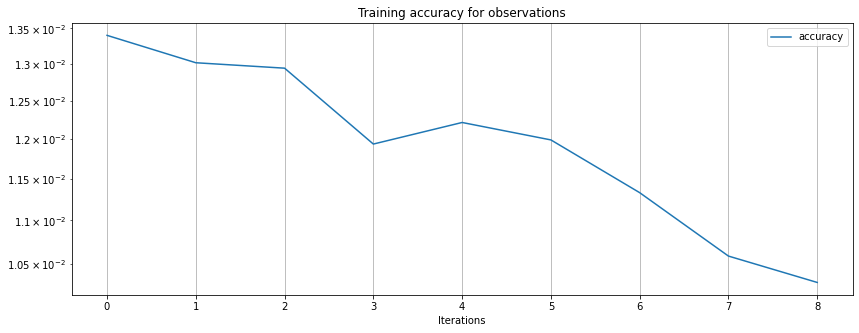

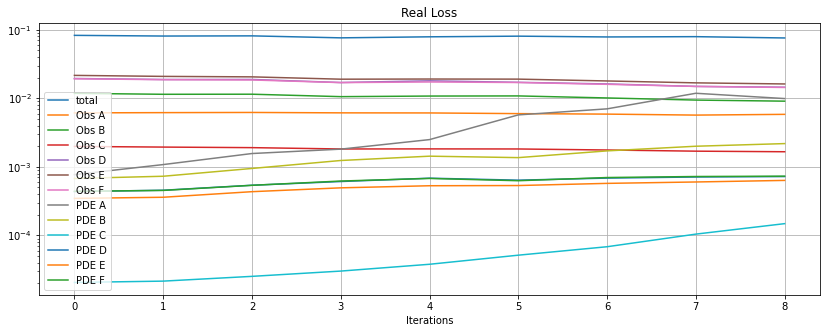

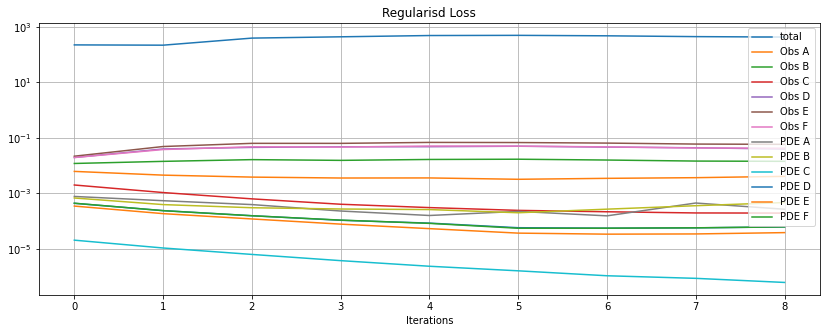

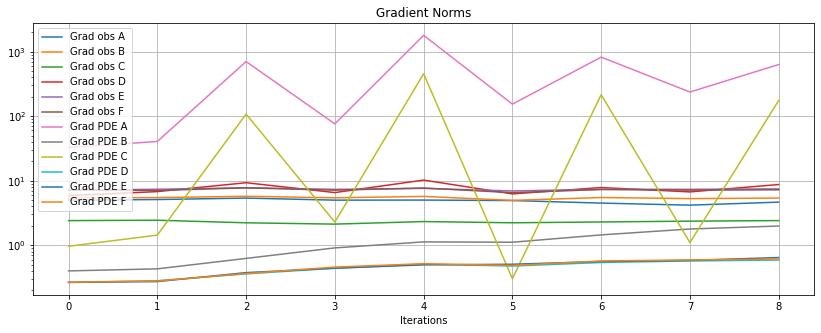

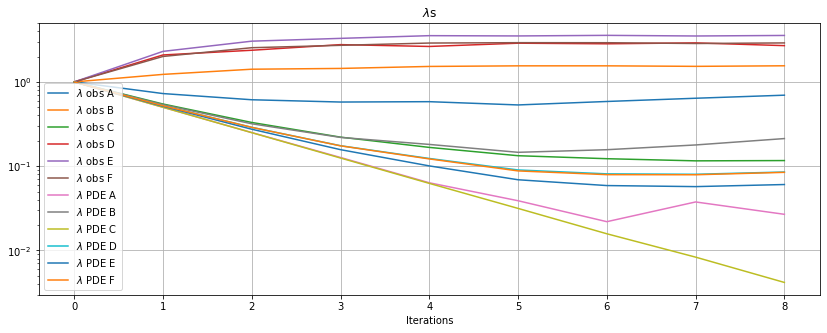

In [30]:
plot_result(results3, node_names=node_names, start = 0)

In [31]:
results4 = model.train(epochs = 60,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.00956146
total loss: 0.07291597, total regularisd loss (sum of batches): 383.45096111
obs A loss: 0.00578874, pde A loss: 0.01063360
obs B loss: 0.00834581, pde B loss: 0.00253966
obs C loss: 0.00158760, pde C loss: 0.00020351
obs D loss: 0.01331944, pde D loss: 0.00074666
obs E loss: 0.01502247, pde E loss: 0.00067340
obs F loss: 0.01330460, pde F loss: 0.00075047
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01794 b_C: 0.00000 b_D: 0.03058 
b_E: 0.00000 b_F: 0.03068 V_A: 4.39733 V_B: 0.00000 
V_C: 2.28426 V_D: 0.57528 V_E: 0.00000 V_F: 0.50963 
k_AA: 17.30456 k_BD: 14.32573 k_CE: 6.46021 k_DA: 0.00000 
k_EB: 7.17030 k_EE: 15.88771 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00850672
total loss: 0.07259601, total regularisd loss (sum of batches): 336.81602629
obs A loss: 0.00609147, pde A loss: 0.01548022
obs B loss: 0.00736928, pde B loss: 0.00346412
obs C loss: 0.00145368, pde C loss: 0.00020020
obs D loss: 0.01155340, pde D loss: 0.00081361
obs E loss: 0.01301635, pde E loss: 0.00076067
obs F loss: 0.01155615, pde F loss: 0.00083686
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01461 b_C: 0.00000 b_D: 0.02495 
b_E: 0.00000 b_F: 0.02501 V_A: 4.20691 V_B: 0.00011 
V_C: 2.17842 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30460 k_BD: 14.41187 k_CE: 6.46021 k_DA: 0.00000 
k_EB: 7.17031 k_EE: 15.88771 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00743970
total loss: 0.06498619, total regularisd loss (sum of batches): 292.48512241
obs A loss: 0.00579310, pde A loss: 0.01320310
obs B loss: 0.00638461, pde B loss: 0.00439497
obs C loss: 0.00132990, pde C loss: 0.00018036
obs D loss: 0.00995448, pde D loss: 0.00089068
obs E loss: 0.01122592, pde E loss: 0.00078714
obs F loss: 0.00995019, pde F loss: 0.00089174
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01632 b_C: 0.00000 b_D: 0.02467 
b_E: 0.00000 b_F: 0.02467 V_A: 3.53104 V_B: 0.00004 
V_C: 1.55870 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30468 k_BD: 14.41189 k_CE: 6.46021 k_DA: 0.00000 
k_EB: 7.17031 k_EE: 15.88771 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00676404
total loss: 0.06412015, total regularisd loss (sum of batches): 263.73846665
obs A loss: 0.00578953, pde A loss: 0.01562892
obs B loss: 0.00576989, pde B loss: 0.00509211
obs C loss: 0.00124522, pde C loss: 0.00016664
obs D loss: 0.00888752, pde D loss: 0.00091968
obs E loss: 0.01000949, pde E loss: 0.00080851
obs F loss: 0.00888261, pde F loss: 0.00092003
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01586 b_C: 0.00000 b_D: 0.02739 
b_E: 0.00000 b_F: 0.02740 V_A: 3.43637 V_B: 0.00116 
V_C: 1.51244 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30481 k_BD: 14.41189 k_CE: 6.46021 k_DA: 0.00000 
k_EB: 7.17032 k_EE: 15.88771 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00641473
total loss: 0.06475658, total regularisd loss (sum of batches): 249.06168907
obs A loss: 0.00577209, pde A loss: 0.01795402
obs B loss: 0.00544451, pde B loss: 0.00544690
obs C loss: 0.00121032, pde C loss: 0.00016486
obs D loss: 0.00832968, pde D loss: 0.00093515
obs E loss: 0.00939153, pde E loss: 0.00083196
obs F loss: 0.00834018, pde F loss: 0.00093537
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01289 b_C: 0.00000 b_D: 0.02569 
b_E: 0.00000 b_F: 0.02569 V_A: 3.13222 V_B: 0.00075 
V_C: 1.30807 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30499 k_BD: 14.41221 k_CE: 6.46021 k_DA: 0.00000 
k_EB: 7.17034 k_EE: 15.88773 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00640710
total loss: 0.06626002, total regularisd loss (sum of batches): 247.46470759
obs A loss: 0.00599897, pde A loss: 0.01902725
obs B loss: 0.00551261, pde B loss: 0.00590629
obs C loss: 0.00119577, pde C loss: 0.00016515
obs D loss: 0.00825769, pde D loss: 0.00092312
obs E loss: 0.00922423, pde E loss: 0.00087065
obs F loss: 0.00825336, pde F loss: 0.00092495
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01915 b_C: 0.00000 b_D: 0.02833 
b_E: 0.00000 b_F: 0.02837 V_A: 2.92826 V_B: 0.00001 
V_C: 1.19383 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30512 k_BD: 14.41237 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17036 k_EE: 15.88779 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00656063
total loss: 0.07627934, total regularisd loss (sum of batches): 255.60810363
obs A loss: 0.00593922, pde A loss: 0.02780019
obs B loss: 0.00559882, pde B loss: 0.00616111
obs C loss: 0.00119939, pde C loss: 0.00016098
obs D loss: 0.00884601, pde D loss: 0.00096738
obs E loss: 0.00938411, pde E loss: 0.00086352
obs F loss: 0.00839622, pde F loss: 0.00096239
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01867 b_C: 0.00000 b_D: 0.02603 
b_E: 0.00000 b_F: 0.02604 V_A: 2.61733 V_B: 0.00000 
V_C: 0.97305 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30527 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17037 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00583554
total loss: 0.06406607, total regularisd loss (sum of batches): 223.17709872
obs A loss: 0.00591571, pde A loss: 0.01954715
obs B loss: 0.00508270, pde B loss: 0.00650292
obs C loss: 0.00112037, pde C loss: 0.00015935
obs D loss: 0.00733342, pde D loss: 0.00098753
obs E loss: 0.00820220, pde E loss: 0.00087693
obs F loss: 0.00735885, pde F loss: 0.00097894
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01950 b_C: 0.00000 b_D: 0.03123 
b_E: 0.00000 b_F: 0.03130 V_A: 0.69781 V_B: 0.00110 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30544 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17039 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

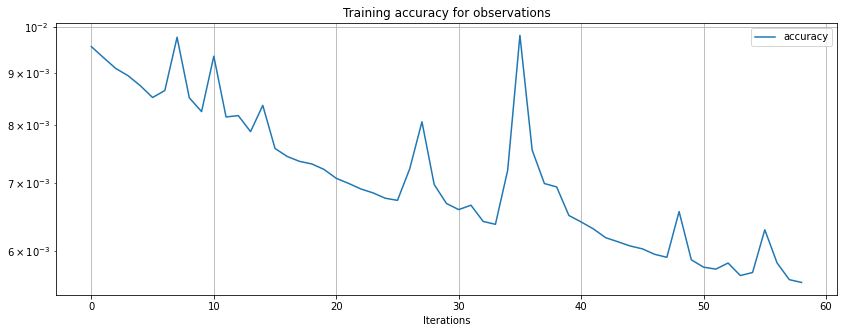

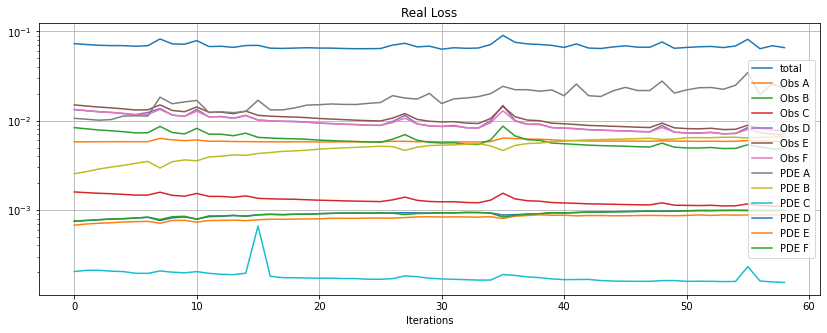

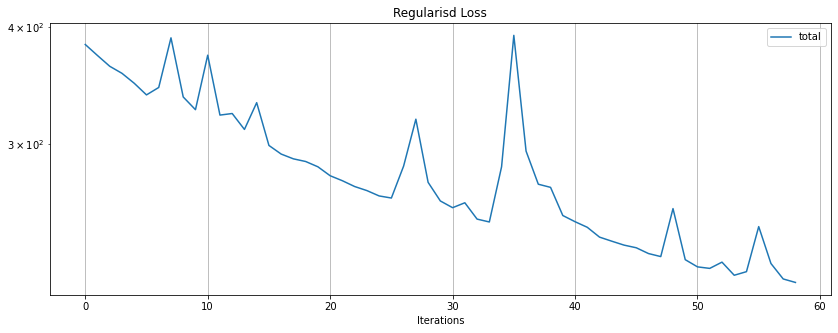

In [34]:
plot_result(results4, node_names=node_names, start = 0)

In [35]:
results5 = model.train(epochs = 5,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.00552749
total loss: 0.06532149, total regularisd loss (sum of batches): 210.72591268
obs A loss: 0.00585147, pde A loss: 0.02244976
obs B loss: 0.00474061, pde B loss: 0.00667295
obs C loss: 0.00108626, pde C loss: 0.00015474
obs D loss: 0.00690807, pde D loss: 0.00099330
obs E loss: 0.00767539, pde E loss: 0.00089228
obs F loss: 0.00690310, pde F loss: 0.00099356
lambda obs A: 0.75738056, lambda pde A: 0.03884798
lambda obs B: 1.51570497, lambda pde B: 0.23851897
lambda obs C: 0.11620467, lambda pde C: 0.00284127
lambda obs D: 2.77399669, lambda pde D: 0.08715937
lambda obs E: 3.48045867, lambda pde E: 0.06353672
lambda obs F: 2.83879075, lambda pde F: 0.08655938
b_A: 0.00000 b_B: 0.01680 b_C: 0.00000 b_D: 0.02542 
b_E: 0.00000 b_F: 0.02543 V_A: 0.62397 V_B: 0.00110 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30552 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17039 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

In [50]:
results6 = model.train(epochs = 60,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.00558183
total loss: 0.05522559, total regularisd loss (sum of batches): 193.06384120
obs A loss: 0.00583055, pde A loss: 0.01510640
obs B loss: 0.00511748, pde B loss: 0.00380447
obs C loss: 0.00109151, pde C loss: 0.00014899
obs D loss: 0.00687738, pde D loss: 0.00092524
obs E loss: 0.00770027, pde E loss: 0.00082415
obs F loss: 0.00687381, pde F loss: 0.00092535
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01435 b_C: 0.00000 b_D: 0.02321 
b_E: 0.00000 b_F: 0.02322 V_A: 0.10469 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30597 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17044 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00541858
total loss: 0.05211456, total regularisd loss (sum of batches): 186.65455710
obs A loss: 0.00569794, pde A loss: 0.01321269
obs B loss: 0.00491137, pde B loss: 0.00358213
obs C loss: 0.00107563, pde C loss: 0.00014751
obs D loss: 0.00667560, pde D loss: 0.00091819
obs E loss: 0.00747863, pde E loss: 0.00082432
obs F loss: 0.00667229, pde F loss: 0.00091825
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01917 b_C: 0.00000 b_D: 0.02909 
b_E: 0.00000 b_F: 0.02910 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30678 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17051 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00531489
total loss: 0.05176623, total regularisd loss (sum of batches): 183.21046214
obs A loss: 0.00565330, pde A loss: 0.01357478
obs B loss: 0.00479162, pde B loss: 0.00350079
obs C loss: 0.00106503, pde C loss: 0.00014435
obs D loss: 0.00652309, pde D loss: 0.00091736
obs E loss: 0.00733642, pde E loss: 0.00082214
obs F loss: 0.00651989, pde F loss: 0.00091746
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01737 b_C: 0.00000 b_D: 0.02487 
b_E: 0.00109 b_F: 0.02488 V_A: 0.00000 V_B: 0.00140 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30763 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17060 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00519831
total loss: 0.05042534, total regularisd loss (sum of batches): 179.13658616
obs A loss: 0.00559317, pde A loss: 0.01293499
obs B loss: 0.00467412, pde B loss: 0.00346967
obs C loss: 0.00105401, pde C loss: 0.00014452
obs D loss: 0.00635177, pde D loss: 0.00092673
obs E loss: 0.00716806, pde E loss: 0.00083273
obs F loss: 0.00634873, pde F loss: 0.00092684
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01484 b_C: 0.00000 b_D: 0.02278 
b_E: 0.00000 b_F: 0.02279 V_A: 0.00000 V_B: 0.00053 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30836 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17066 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00511491
total loss: 0.05057148, total regularisd loss (sum of batches): 176.50794059
obs A loss: 0.00555999, pde A loss: 0.01363708
obs B loss: 0.00458560, pde B loss: 0.00342391
obs C loss: 0.00104228, pde C loss: 0.00014367
obs D loss: 0.00624389, pde D loss: 0.00092297
obs E loss: 0.00701675, pde E loss: 0.00083131
obs F loss: 0.00624094, pde F loss: 0.00092309
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01922 b_C: 0.00000 b_D: 0.02716 
b_E: 0.00000 b_F: 0.02717 V_A: 0.00000 V_B: 0.00085 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30908 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17073 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00504481
total loss: 0.05053686, total regularisd loss (sum of batches): 174.29311533
obs A loss: 0.00551717, pde A loss: 0.01403712
obs B loss: 0.00450801, pde B loss: 0.00339003
obs C loss: 0.00103339, pde C loss: 0.00014363
obs D loss: 0.00615338, pde D loss: 0.00093045
obs E loss: 0.00690632, pde E loss: 0.00083621
obs F loss: 0.00615057, pde F loss: 0.00093058
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01618 b_C: 0.00000 b_D: 0.02321 
b_E: 0.00000 b_F: 0.02322 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.30976 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17078 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00496391
total loss: 0.04922795, total regularisd loss (sum of batches): 171.32843248
obs A loss: 0.00548810, pde A loss: 0.01319684
obs B loss: 0.00443546, pde B loss: 0.00337599
obs C loss: 0.00102586, pde C loss: 0.00014436
obs D loss: 0.00603218, pde D loss: 0.00094227
obs E loss: 0.00677248, pde E loss: 0.00084258
obs F loss: 0.00602942, pde F loss: 0.00094240
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01560 b_C: 0.00000 b_D: 0.02312 
b_E: 0.00000 b_F: 0.02313 V_A: 0.00000 V_B: 0.00008 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31049 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17085 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00491095
total loss: 0.04721771, total regularisd loss (sum of batches): 169.04239456
obs A loss: 0.00545467, pde A loss: 0.01151552
obs B loss: 0.00438623, pde B loss: 0.00336744
obs C loss: 0.00101910, pde C loss: 0.00014251
obs D loss: 0.00595538, pde D loss: 0.00094173
obs E loss: 0.00669766, pde E loss: 0.00084294
obs F loss: 0.00595269, pde F loss: 0.00094186
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.01815 b_C: 0.00000 b_D: 0.02743 
b_E: 0.00000 b_F: 0.02744 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31122 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17090 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [51]:
results7 = model.train(epochs = 10,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.00487751
total loss: 0.04894878, total regularisd loss (sum of batches): 168.54623901
obs A loss: 0.00546315, pde A loss: 0.01345590
obs B loss: 0.00435360, pde B loss: 0.00336120
obs C loss: 0.00101319, pde C loss: 0.00014173
obs D loss: 0.00590332, pde D loss: 0.00094203
obs E loss: 0.00663114, pde E loss: 0.00084070
obs F loss: 0.00590067, pde F loss: 0.00094216
lambda obs A: 1.83028807, lambda pde A: 0.12243390
lambda obs B: 1.75118012, lambda pde B: 0.92390208
lambda obs C: 0.14741492, lambda pde C: 0.00932930
lambda obs D: 2.06767501, lambda pde D: 0.22477491
lambda obs E: 2.47683508, lambda pde E: 0.15311845
lambda obs F: 2.06839565, lambda pde F: 0.22465251
b_A: 0.00000 b_B: 0.02120 b_C: 0.00000 b_D: 0.02770 
b_E: 0.00000 b_F: 0.02771 V_A: 0.00000 V_B: 0.00243 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31157 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17093 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00488255
total loss: 0.04940418, total regularisd loss (sum of batches): 162.99513521
obs A loss: 0.00533877, pde A loss: 0.01439040
obs B loss: 0.00450721, pde B loss: 0.00290871
obs C loss: 0.00101214, pde C loss: 0.00014062
obs D loss: 0.00591569, pde D loss: 0.00092138
obs E loss: 0.00660842, pde E loss: 0.00082631
obs F loss: 0.00591306, pde F loss: 0.00092149
lambda obs A: 2.27118126, lambda pde A: 0.13997963
lambda obs B: 1.71901456, lambda pde B: 1.11832867
lambda obs C: 0.15982650, lambda pde C: 0.01094355
lambda obs D: 1.83515828, lambda pde D: 0.28245457
lambda obs E: 2.15669517, lambda pde E: 0.19001812
lambda obs F: 1.83398307, lambda pde F: 0.28241661
b_A: 0.00000 b_B: 0.01135 b_C: 0.00000 b_D: 0.02326 
b_E: 0.00000 b_F: 0.02327 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31222 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17098 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [52]:
results8 = model.train(epochs = 60,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.00486030
total loss: 0.04819390, total regularisd loss (sum of batches): 162.17194774
obs A loss: 0.00532922, pde A loss: 0.01330056
obs B loss: 0.00447178, pde B loss: 0.00291866
obs C loss: 0.00101326, pde C loss: 0.00014020
obs D loss: 0.00587017, pde D loss: 0.00092223
obs E loss: 0.00660982, pde E loss: 0.00082815
obs F loss: 0.00586754, pde F loss: 0.00092233
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01029 b_C: 0.00000 b_D: 0.02349 
b_E: 0.00000 b_F: 0.02350 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31237 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17099 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00478883
total loss: 0.04785773, total regularisd loss (sum of batches): 159.92724995
obs A loss: 0.00525161, pde A loss: 0.01341992
obs B loss: 0.00440505, pde B loss: 0.00288797
obs C loss: 0.00100706, pde C loss: 0.00014025
obs D loss: 0.00578317, pde D loss: 0.00092255
obs E loss: 0.00650547, pde E loss: 0.00083140
obs F loss: 0.00578062, pde F loss: 0.00092264
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01396 b_C: 0.00000 b_D: 0.02515 
b_E: 0.00000 b_F: 0.02516 V_A: 0.00000 V_B: 0.00002 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31294 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17103 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00476319
total loss: 0.04829972, total regularisd loss (sum of batches): 159.22272213
obs A loss: 0.00518472, pde A loss: 0.01404818
obs B loss: 0.00438224, pde B loss: 0.00285414
obs C loss: 0.00100030, pde C loss: 0.00013913
obs D loss: 0.00577301, pde D loss: 0.00092420
obs E loss: 0.00646830, pde E loss: 0.00083072
obs F loss: 0.00577051, pde F loss: 0.00092427
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01898 b_C: 0.00000 b_D: 0.02460 
b_E: 0.00021 b_F: 0.02461 V_A: 0.00000 V_B: 0.00066 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31339 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17106 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00470656
total loss: 0.04775441, total regularisd loss (sum of batches): 157.29373294
obs A loss: 0.00507028, pde A loss: 0.01385490
obs B loss: 0.00434186, pde B loss: 0.00283512
obs C loss: 0.00099774, pde C loss: 0.00013995
obs D loss: 0.00571536, pde D loss: 0.00092261
obs E loss: 0.00640114, pde E loss: 0.00083981
obs F loss: 0.00571296, pde F loss: 0.00092267
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01796 b_C: 0.00000 b_D: 0.02603 
b_E: 0.00000 b_F: 0.02604 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31380 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17108 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00464539
total loss: 0.04898265, total regularisd loss (sum of batches): 155.72475694
obs A loss: 0.00480956, pde A loss: 0.01548674
obs B loss: 0.00431149, pde B loss: 0.00280517
obs C loss: 0.00099476, pde C loss: 0.00013780
obs D loss: 0.00568561, pde D loss: 0.00092504
obs E loss: 0.00638762, pde E loss: 0.00083047
obs F loss: 0.00568331, pde F loss: 0.00092508
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01981 b_C: 0.00000 b_D: 0.02809 
b_E: 0.00000 b_F: 0.02810 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31402 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17109 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00458489
total loss: 0.04917192, total regularisd loss (sum of batches): 153.81311175
obs A loss: 0.00457206, pde A loss: 0.01606714
obs B loss: 0.00427644, pde B loss: 0.00278813
obs C loss: 0.00099263, pde C loss: 0.00013896
obs D loss: 0.00566724, pde D loss: 0.00092063
obs E loss: 0.00633590, pde E loss: 0.00082711
obs F loss: 0.00566503, pde F loss: 0.00092065
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01683 b_C: 0.00000 b_D: 0.02667 
b_E: 0.00000 b_F: 0.02667 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31412 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17110 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00453090
total loss: 0.04803355, total regularisd loss (sum of batches): 151.75120485
obs A loss: 0.00444941, pde A loss: 0.01527101
obs B loss: 0.00424209, pde B loss: 0.00277687
obs C loss: 0.00098752, pde C loss: 0.00013771
obs D loss: 0.00562555, pde D loss: 0.00091760
obs E loss: 0.00625734, pde E loss: 0.00082736
obs F loss: 0.00562347, pde F loss: 0.00091762
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01546 b_C: 0.00000 b_D: 0.02476 
b_E: 0.00000 b_F: 0.02476 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31422 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17110 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00449371
total loss: 0.04807296, total regularisd loss (sum of batches): 150.66139147
obs A loss: 0.00437343, pde A loss: 0.01551667
obs B loss: 0.00421379, pde B loss: 0.00276929
obs C loss: 0.00098682, pde C loss: 0.00013837
obs D loss: 0.00557538, pde D loss: 0.00092679
obs E loss: 0.00623967, pde E loss: 0.00083274
obs F loss: 0.00557319, pde F loss: 0.00092681
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01642 b_C: 0.00000 b_D: 0.02635 
b_E: 0.00000 b_F: 0.02636 V_A: 0.00000 V_B: 0.00004 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31432 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17110 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [55]:
results9 = model.train(epochs = 60,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.00447985
total loss: 0.04798509, total regularisd loss (sum of batches): 150.20054922
obs A loss: 0.00435100, pde A loss: 0.01550824
obs B loss: 0.00420468, pde B loss: 0.00276205
obs C loss: 0.00098488, pde C loss: 0.00013924
obs D loss: 0.00556848, pde D loss: 0.00093088
obs E loss: 0.00620387, pde E loss: 0.00083463
obs F loss: 0.00556623, pde F loss: 0.00093091
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01460 b_C: 0.00000 b_D: 0.02648 
b_E: 0.00000 b_F: 0.02649 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31435 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17111 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00444824
total loss: 0.04621726, total regularisd loss (sum of batches): 148.62171997
obs A loss: 0.00429099, pde A loss: 0.01394365
obs B loss: 0.00417531, pde B loss: 0.00275451
obs C loss: 0.00098058, pde C loss: 0.00013763
obs D loss: 0.00554206, pde D loss: 0.00092962
obs E loss: 0.00616076, pde E loss: 0.00083273
obs F loss: 0.00553977, pde F loss: 0.00092966
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01920 b_C: 0.00000 b_D: 0.02564 
b_E: 0.00000 b_F: 0.02564 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31446 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17111 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00440864
total loss: 0.04566899, total regularisd loss (sum of batches): 147.31331964
obs A loss: 0.00426433, pde A loss: 0.01361511
obs B loss: 0.00414014, pde B loss: 0.00275585
obs C loss: 0.00097881, pde C loss: 0.00013771
obs D loss: 0.00548298, pde D loss: 0.00093573
obs E loss: 0.00610489, pde E loss: 0.00083698
obs F loss: 0.00548073, pde F loss: 0.00093575
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01190 b_C: 0.00000 b_D: 0.02438 
b_E: 0.00000 b_F: 0.02439 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31458 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17111 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00438881
total loss: 0.04498577, total regularisd loss (sum of batches): 146.52523060
obs A loss: 0.00424149, pde A loss: 0.01302834
obs B loss: 0.00411992, pde B loss: 0.00276300
obs C loss: 0.00097739, pde C loss: 0.00013814
obs D loss: 0.00545815, pde D loss: 0.00094189
obs E loss: 0.00608001, pde E loss: 0.00083962
obs F loss: 0.00545592, pde F loss: 0.00094189
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01688 b_C: 0.00000 b_D: 0.02513 
b_E: 0.00000 b_F: 0.02514 V_A: 0.00309 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31471 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17112 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00435370
total loss: 0.04520049, total regularisd loss (sum of batches): 145.61011834
obs A loss: 0.00422052, pde A loss: 0.01343576
obs B loss: 0.00408506, pde B loss: 0.00276301
obs C loss: 0.00097188, pde C loss: 0.00013785
obs D loss: 0.00541962, pde D loss: 0.00094839
obs E loss: 0.00600766, pde E loss: 0.00084491
obs F loss: 0.00541744, pde F loss: 0.00094839
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01845 b_C: 0.00000 b_D: 0.02452 
b_E: 0.00000 b_F: 0.02453 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31486 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17112 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00433480
total loss: 0.04408033, total regularisd loss (sum of batches): 144.64021103
obs A loss: 0.00419535, pde A loss: 0.01244390
obs B loss: 0.00406989, pde B loss: 0.00275494
obs C loss: 0.00096918, pde C loss: 0.00013757
obs D loss: 0.00539965, pde D loss: 0.00094484
obs E loss: 0.00597724, pde E loss: 0.00084543
obs F loss: 0.00539748, pde F loss: 0.00094483
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01401 b_C: 0.00000 b_D: 0.02241 
b_E: 0.00000 b_F: 0.02241 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31499 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17113 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00431274
total loss: 0.04542771, total regularisd loss (sum of batches): 144.49843536
obs A loss: 0.00417963, pde A loss: 0.01391778
obs B loss: 0.00404580, pde B loss: 0.00274830
obs C loss: 0.00096636, pde C loss: 0.00013785
obs D loss: 0.00536440, pde D loss: 0.00094793
obs E loss: 0.00595799, pde E loss: 0.00085149
obs F loss: 0.00536227, pde F loss: 0.00094791
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01831 b_C: 0.00000 b_D: 0.02981 
b_E: 0.00000 b_F: 0.02982 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31509 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17113 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00427259
total loss: 0.04439403, total regularisd loss (sum of batches): 143.00376855
obs A loss: 0.00413642, pde A loss: 0.01309607
obs B loss: 0.00401596, pde B loss: 0.00275482
obs C loss: 0.00096345, pde C loss: 0.00013835
obs D loss: 0.00530918, pde D loss: 0.00095813
obs E loss: 0.00590342, pde E loss: 0.00085302
obs F loss: 0.00530710, pde F loss: 0.00095810
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01707 b_C: 0.00000 b_D: 0.02648 
b_E: 0.00000 b_F: 0.02649 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31522 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17114 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [66]:
results10 = model.train(epochs = 20,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.00426613
total loss: 0.04429752, total regularisd loss (sum of batches): 142.75369727
obs A loss: 0.00412940, pde A loss: 0.01306716
obs B loss: 0.00399906, pde B loss: 0.00274916
obs C loss: 0.00096377, pde C loss: 0.00013827
obs D loss: 0.00530857, pde D loss: 0.00094984
obs E loss: 0.00588947, pde E loss: 0.00084653
obs F loss: 0.00530649, pde F loss: 0.00094981
lambda obs A: 2.26885300, lambda pde A: 0.13435530
lambda obs B: 1.71012056, lambda pde B: 1.12423059
lambda obs C: 0.15996797, lambda pde C: 0.01095437
lambda obs D: 1.83349870, lambda pde D: 0.28178529
lambda obs E: 2.16843460, lambda pde E: 0.19371996
lambda obs F: 1.83233127, lambda pde F: 0.28174839
b_A: 0.00000 b_B: 0.01862 b_C: 0.00000 b_D: 0.02823 
b_E: 0.00000 b_F: 0.02823 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31528 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17114 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00428710
total loss: 0.04379433, total regularisd loss (sum of batches): 140.58551292
obs A loss: 0.00417976, pde A loss: 0.01261777
obs B loss: 0.00407640, pde B loss: 0.00258895
obs C loss: 0.00096347, pde C loss: 0.00013607
obs D loss: 0.00530736, pde D loss: 0.00094536
obs E loss: 0.00589030, pde E loss: 0.00083827
obs F loss: 0.00530528, pde F loss: 0.00094533
lambda obs A: 1.86604919, lambda pde A: 0.14689636
lambda obs B: 1.75574124, lambda pde B: 1.27169454
lambda obs C: 0.17976320, lambda pde C: 0.01271844
lambda obs D: 1.85084371, lambda pde D: 0.33913930
lambda obs E: 2.14762669, lambda pde E: 0.24064290
lambda obs F: 1.84984242, lambda pde F: 0.33904201
b_A: 0.00000 b_B: 0.01322 b_C: 0.00000 b_D: 0.02684 
b_E: 0.00002 b_F: 0.02685 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31535 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17114 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00425553
total loss: 0.04260972, total regularisd loss (sum of batches): 139.28055830
obs A loss: 0.00416421, pde A loss: 0.01163014
obs B loss: 0.00404845, pde B loss: 0.00258339
obs C loss: 0.00096167, pde C loss: 0.00013515
obs D loss: 0.00525593, pde D loss: 0.00094351
obs E loss: 0.00584904, pde E loss: 0.00084085
obs F loss: 0.00525390, pde F loss: 0.00094347
lambda obs A: 1.89662525, lambda pde A: 0.14250696
lambda obs B: 1.75039426, lambda pde B: 1.26510705
lambda obs C: 0.18037991, lambda pde C: 0.01273480
lambda obs D: 1.84595268, lambda pde D: 0.34194855
lambda obs E: 2.13127049, lambda pde E: 0.24624513
lambda obs F: 1.84498732, lambda pde F: 0.34184761
b_A: 0.00000 b_B: 0.01495 b_C: 0.00000 b_D: 0.02463 
b_E: 0.00000 b_F: 0.02464 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31544 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17114 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [67]:
results11 = model.train(epochs = 3*60,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.00425600
total loss: 0.04303440, total regularisd loss (sum of batches): 139.51264804
obs A loss: 0.00414251, pde A loss: 0.01205208
obs B loss: 0.00403219, pde B loss: 0.00258384
obs C loss: 0.00095979, pde C loss: 0.00013533
obs D loss: 0.00527298, pde D loss: 0.00094436
obs E loss: 0.00585762, pde E loss: 0.00083844
obs F loss: 0.00527095, pde F loss: 0.00094431
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01556 b_C: 0.00000 b_D: 0.02608 
b_E: 0.00013 b_F: 0.02609 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31549 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17115 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00422410
total loss: 0.04279237, total regularisd loss (sum of batches): 138.50982887
obs A loss: 0.00412548, pde A loss: 0.01201156
obs B loss: 0.00401788, pde B loss: 0.00257826
obs C loss: 0.00095495, pde C loss: 0.00013480
obs D loss: 0.00522733, pde D loss: 0.00093918
obs E loss: 0.00579362, pde E loss: 0.00084483
obs F loss: 0.00522535, pde F loss: 0.00093913
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01664 b_C: 0.00000 b_D: 0.02921 
b_E: 0.00000 b_F: 0.02921 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31559 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17115 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00420051
total loss: 0.04242754, total regularisd loss (sum of batches): 137.71295850
obs A loss: 0.00410765, pde A loss: 0.01177548
obs B loss: 0.00399555, pde B loss: 0.00257157
obs C loss: 0.00095396, pde C loss: 0.00013484
obs D loss: 0.00519250, pde D loss: 0.00094742
obs E loss: 0.00576287, pde E loss: 0.00084780
obs F loss: 0.00519054, pde F loss: 0.00094736
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01565 b_C: 0.00000 b_D: 0.02457 
b_E: 0.00000 b_F: 0.02458 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31567 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17115 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00419787
total loss: 0.04312983, total regularisd loss (sum of batches): 137.83934173
obs A loss: 0.00410466, pde A loss: 0.01252897
obs B loss: 0.00399221, pde B loss: 0.00255519
obs C loss: 0.00095300, pde C loss: 0.00013394
obs D loss: 0.00519417, pde D loss: 0.00094444
obs E loss: 0.00575101, pde E loss: 0.00083566
obs F loss: 0.00519221, pde F loss: 0.00094437
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01836 b_C: 0.00000 b_D: 0.02861 
b_E: 0.00000 b_F: 0.02861 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31575 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17115 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00417566
total loss: 0.04276287, total regularisd loss (sum of batches): 137.12556200
obs A loss: 0.00407443, pde A loss: 0.01227737
obs B loss: 0.00395814, pde B loss: 0.00256173
obs C loss: 0.00095202, pde C loss: 0.00013501
obs D loss: 0.00516837, pde D loss: 0.00094486
obs E loss: 0.00573461, pde E loss: 0.00084514
obs F loss: 0.00516643, pde F loss: 0.00094479
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01579 b_C: 0.00000 b_D: 0.02696 
b_E: 0.00000 b_F: 0.02696 V_A: 0.00916 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31582 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17116 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00414744
total loss: 0.04217755, total regularisd loss (sum of batches): 136.09545273
obs A loss: 0.00405894, pde A loss: 0.01187977
obs B loss: 0.00394329, pde B loss: 0.00255063
obs C loss: 0.00094546, pde C loss: 0.00013228
obs D loss: 0.00513187, pde D loss: 0.00094597
obs E loss: 0.00567513, pde E loss: 0.00083838
obs F loss: 0.00512996, pde F loss: 0.00094589
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01191 b_C: 0.00000 b_D: 0.02736 
b_E: 0.00000 b_F: 0.02737 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31590 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17116 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00414881
total loss: 0.04191930, total regularisd loss (sum of batches): 136.02063578
obs A loss: 0.00404184, pde A loss: 0.01159797
obs B loss: 0.00394648, pde B loss: 0.00254282
obs C loss: 0.00094809, pde C loss: 0.00013540
obs D loss: 0.00513667, pde D loss: 0.00094932
obs E loss: 0.00568507, pde E loss: 0.00085166
obs F loss: 0.00513474, pde F loss: 0.00094925
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01450 b_C: 0.00000 b_D: 0.02463 
b_E: 0.00000 b_F: 0.02464 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31595 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17116 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00414901
total loss: 0.04165798, total regularisd loss (sum of batches): 135.90843768
obs A loss: 0.00406292, pde A loss: 0.01136354
obs B loss: 0.00394255, pde B loss: 0.00253987
obs C loss: 0.00094664, pde C loss: 0.00013312
obs D loss: 0.00513790, pde D loss: 0.00094266
obs E loss: 0.00566809, pde E loss: 0.00084212
obs F loss: 0.00513598, pde F loss: 0.00094258
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.00974 b_C: 0.00000 b_D: 0.02157 
b_E: 0.00000 b_F: 0.02158 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31602 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17116 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00410982
total loss: 0.04213464, total regularisd loss (sum of batches): 134.98369075
obs A loss: 0.00401761, pde A loss: 0.01206620
obs B loss: 0.00391319, pde B loss: 0.00253062
obs C loss: 0.00094238, pde C loss: 0.00013278
obs D loss: 0.00508364, pde D loss: 0.00094898
obs E loss: 0.00562035, pde E loss: 0.00084823
obs F loss: 0.00508175, pde F loss: 0.00094890
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01128 b_C: 0.00000 b_D: 0.02507 
b_E: 0.00000 b_F: 0.02508 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31608 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00414756
total loss: 0.04291737, total regularisd loss (sum of batches): 136.29506910
obs A loss: 0.00401747, pde A loss: 0.01262827
obs B loss: 0.00395479, pde B loss: 0.00252180
obs C loss: 0.00094655, pde C loss: 0.00013457
obs D loss: 0.00513616, pde D loss: 0.00094848
obs E loss: 0.00569616, pde E loss: 0.00085049
obs F loss: 0.00513422, pde F loss: 0.00094840
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01680 b_C: 0.00000 b_D: 0.02563 
b_E: 0.00116 b_F: 0.02564 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31614 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00409168
total loss: 0.04174182, total regularisd loss (sum of batches): 134.29591818
obs A loss: 0.00398568, pde A loss: 0.01176697
obs B loss: 0.00390188, pde B loss: 0.00251920
obs C loss: 0.00094262, pde C loss: 0.00013450
obs D loss: 0.00506576, pde D loss: 0.00095547
obs E loss: 0.00559025, pde E loss: 0.00086021
obs F loss: 0.00506388, pde F loss: 0.00095539
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01809 b_C: 0.00000 b_D: 0.02491 
b_E: 0.00000 b_F: 0.02492 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31622 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00408551
total loss: 0.04207042, total regularisd loss (sum of batches): 134.23374465
obs A loss: 0.00397583, pde A loss: 0.01214950
obs B loss: 0.00389783, pde B loss: 0.00251269
obs C loss: 0.00094197, pde C loss: 0.00013350
obs D loss: 0.00505687, pde D loss: 0.00095510
obs E loss: 0.00558554, pde E loss: 0.00085158
obs F loss: 0.00505500, pde F loss: 0.00095502
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01483 b_C: 0.00000 b_D: 0.02746 
b_E: 0.00000 b_F: 0.02747 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31627 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00405236
total loss: 0.04185709, total regularisd loss (sum of batches): 133.23834618
obs A loss: 0.00395540, pde A loss: 0.01212357
obs B loss: 0.00387384, pde B loss: 0.00251076
obs C loss: 0.00093899, pde C loss: 0.00013484
obs D loss: 0.00500433, pde D loss: 0.00095862
obs E loss: 0.00553912, pde E loss: 0.00085660
obs F loss: 0.00500249, pde F loss: 0.00095853
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01309 b_C: 0.00000 b_D: 0.02381 
b_E: 0.00081 b_F: 0.02381 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31632 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00404779
total loss: 0.04292306, total regularisd loss (sum of batches): 133.46500882
obs A loss: 0.00392679, pde A loss: 0.01323278
obs B loss: 0.00387230, pde B loss: 0.00250050
obs C loss: 0.00093559, pde C loss: 0.00013443
obs D loss: 0.00501421, pde D loss: 0.00095582
obs E loss: 0.00552547, pde E loss: 0.00085706
obs F loss: 0.00501237, pde F loss: 0.00095574
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01630 b_C: 0.00000 b_D: 0.02619 
b_E: 0.00010 b_F: 0.02620 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31638 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00403823
total loss: 0.04195170, total regularisd loss (sum of batches): 132.84939104
obs A loss: 0.00390983, pde A loss: 0.01232389
obs B loss: 0.00386869, pde B loss: 0.00250170
obs C loss: 0.00093529, pde C loss: 0.00013174
obs D loss: 0.00500241, pde D loss: 0.00095503
obs E loss: 0.00551255, pde E loss: 0.00085504
obs F loss: 0.00500059, pde F loss: 0.00095494
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01952 b_C: 0.00000 b_D: 0.02610 
b_E: 0.00000 b_F: 0.02611 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31641 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00400968
total loss: 0.04060041, total regularisd loss (sum of batches): 131.59309652
obs A loss: 0.00386592, pde A loss: 0.01110528
obs B loss: 0.00385027, pde B loss: 0.00250566
obs C loss: 0.00093368, pde C loss: 0.00013432
obs D loss: 0.00496092, pde D loss: 0.00096351
obs E loss: 0.00548817, pde E loss: 0.00087013
obs F loss: 0.00495912, pde F loss: 0.00096343
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01846 b_C: 0.00000 b_D: 0.02727 
b_E: 0.00000 b_F: 0.02728 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31644 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17117 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00400363
total loss: 0.04189696, total regularisd loss (sum of batches): 131.86668870
obs A loss: 0.00384575, pde A loss: 0.01245847
obs B loss: 0.00384918, pde B loss: 0.00250168
obs C loss: 0.00093364, pde C loss: 0.00013316
obs D loss: 0.00496330, pde D loss: 0.00095992
obs E loss: 0.00546837, pde E loss: 0.00086215
obs F loss: 0.00496151, pde F loss: 0.00095983
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01547 b_C: 0.00000 b_D: 0.02567 
b_E: 0.00000 b_F: 0.02568 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31646 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00398193
total loss: 0.04051661, total regularisd loss (sum of batches): 130.76371878
obs A loss: 0.00382606, pde A loss: 0.01121520
obs B loss: 0.00384167, pde B loss: 0.00250139
obs C loss: 0.00092970, pde C loss: 0.00013310
obs D loss: 0.00492899, pde D loss: 0.00095609
obs E loss: 0.00543795, pde E loss: 0.00086323
obs F loss: 0.00492722, pde F loss: 0.00095601
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01365 b_C: 0.00000 b_D: 0.02482 
b_E: 0.00000 b_F: 0.02482 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31648 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00397427
total loss: 0.04071755, total regularisd loss (sum of batches): 130.64273134
obs A loss: 0.00380855, pde A loss: 0.01146140
obs B loss: 0.00382432, pde B loss: 0.00250348
obs C loss: 0.00092919, pde C loss: 0.00013287
obs D loss: 0.00492461, pde D loss: 0.00095706
obs E loss: 0.00543610, pde E loss: 0.00086014
obs F loss: 0.00492286, pde F loss: 0.00095697
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01643 b_C: 0.00000 b_D: 0.02669 
b_E: 0.00092 b_F: 0.02670 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31649 k_BD: 14.41238 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00396535
total loss: 0.04149226, total regularisd loss (sum of batches): 130.67043680
obs A loss: 0.00380066, pde A loss: 0.01226941
obs B loss: 0.00381443, pde B loss: 0.00249948
obs C loss: 0.00092811, pde C loss: 0.00013461
obs D loss: 0.00491626, pde D loss: 0.00096566
obs E loss: 0.00541812, pde E loss: 0.00086542
obs F loss: 0.00491451, pde F loss: 0.00096558
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.02016 b_C: 0.00000 b_D: 0.02605 
b_E: 0.00000 b_F: 0.02606 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31653 k_BD: 14.41239 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00394746
total loss: 0.04116829, total regularisd loss (sum of batches): 130.06770656
obs A loss: 0.00378950, pde A loss: 0.01205866
obs B loss: 0.00380156, pde B loss: 0.00250148
obs C loss: 0.00092668, pde C loss: 0.00013261
obs D loss: 0.00488612, pde D loss: 0.00096396
obs E loss: 0.00539648, pde E loss: 0.00086299
obs F loss: 0.00488439, pde F loss: 0.00096388
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01813 b_C: 0.00000 b_D: 0.02617 
b_E: 0.00000 b_F: 0.02618 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31654 k_BD: 14.41239 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00395107
total loss: 0.04109663, total regularisd loss (sum of batches): 130.09975609
obs A loss: 0.00378645, pde A loss: 0.01197752
obs B loss: 0.00380966, pde B loss: 0.00249169
obs C loss: 0.00092800, pde C loss: 0.00013336
obs D loss: 0.00489208, pde D loss: 0.00096104
obs E loss: 0.00539994, pde E loss: 0.00086558
obs F loss: 0.00489034, pde F loss: 0.00096096
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01660 b_C: 0.00000 b_D: 0.02819 
b_E: 0.00000 b_F: 0.02820 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31657 k_BD: 14.41239 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00393827
total loss: 0.04118485, total regularisd loss (sum of batches): 129.78227274
obs A loss: 0.00377485, pde A loss: 0.01213968
obs B loss: 0.00378508, pde B loss: 0.00249368
obs C loss: 0.00092558, pde C loss: 0.00013236
obs D loss: 0.00488892, pde D loss: 0.00096062
obs E loss: 0.00536799, pde E loss: 0.00086836
obs F loss: 0.00488720, pde F loss: 0.00096054
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.02120 b_C: 0.00000 b_D: 0.02887 
b_E: 0.00000 b_F: 0.02888 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31657 k_BD: 14.41239 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [68]:
results12 = model.train(epochs = 10,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.00392625
total loss: 0.04133055, total regularisd loss (sum of batches): 129.48954310
obs A loss: 0.00376996, pde A loss: 0.01236991
obs B loss: 0.00378571, pde B loss: 0.00249080
obs C loss: 0.00092507, pde C loss: 0.00013206
obs D loss: 0.00485936, pde D loss: 0.00095813
obs E loss: 0.00535979, pde E loss: 0.00086407
obs F loss: 0.00485765, pde F loss: 0.00095805
lambda obs A: 1.89593890, lambda pde A: 0.13796722
lambda obs B: 1.74799100, lambda pde B: 1.25676649
lambda obs C: 0.18222576, lambda pde C: 0.01275255
lambda obs D: 1.84226674, lambda pde D: 0.33928140
lambda obs E: 2.15978053, lambda pde E: 0.24456476
lambda obs F: 1.84127852, lambda pde F: 0.33918613
b_A: 0.00000 b_B: 0.01236 b_C: 0.00000 b_D: 0.02438 
b_E: 0.00034 b_F: 0.02438 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31658 k_BD: 14.41239 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88780 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00394013
total loss: 0.04024173, total regularisd loss (sum of batches): 127.42645212
obs A loss: 0.00378787, pde A loss: 0.01128885
obs B loss: 0.00382872, pde B loss: 0.00240091
obs C loss: 0.00092478, pde C loss: 0.00013268
obs D loss: 0.00487240, pde D loss: 0.00096022
obs E loss: 0.00535632, pde E loss: 0.00085816
obs F loss: 0.00487068, pde F loss: 0.00096014
lambda obs A: 1.81380034, lambda pde A: 0.14479850
lambda obs B: 1.74457789, lambda pde B: 1.36015440
lambda obs C: 0.18863477, lambda pde C: 0.01368250
lambda obs D: 1.80878043, lambda pde D: 0.38682570
lambda obs E: 2.06063121, lambda pde E: 0.28348807
lambda obs F: 1.80792653, lambda pde F: 0.38669966
b_A: 0.00000 b_B: 0.01364 b_C: 0.00000 b_D: 0.02651 
b_E: 0.00000 b_F: 0.02652 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31659 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [69]:
results13 = model.train(epochs = 60,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.00393391
total loss: 0.04001205, total regularisd loss (sum of batches): 126.96324123
obs A loss: 0.00377891, pde A loss: 0.01113422
obs B loss: 0.00383745, pde B loss: 0.00237466
obs C loss: 0.00092246, pde C loss: 0.00013180
obs D loss: 0.00485989, pde D loss: 0.00095488
obs E loss: 0.00534658, pde E loss: 0.00085825
obs F loss: 0.00485817, pde F loss: 0.00095479
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.02303 b_C: 0.00000 b_D: 0.02791 
b_E: 0.00000 b_F: 0.02792 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31661 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 

Training observations acc over epoch: 0.00391433
total loss: 0.03978795, total regularisd loss (sum of batches): 126.31666165
obs A loss: 0.00376591, pde A loss: 0.01103692
obs B loss: 0.00382124, pde B loss: 0.00236919
obs C loss: 0.00092165, pde C loss: 0.00013170
obs D loss: 0.00483898, pde D loss: 0.00095320
obs E loss: 0.00530086, pde E loss: 0.00085790
obs F loss: 0.00483729, pde F loss: 0.00095312
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01478 b_C: 0.00000 b_D: 0.02321 
b_E: 0.00000 b_F: 0.02322 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31661 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00392012
total loss: 0.04012979, total regularisd loss (sum of batches): 126.61754312
obs A loss: 0.00376847, pde A loss: 0.01135379
obs B loss: 0.00381870, pde B loss: 0.00236676
obs C loss: 0.00091985, pde C loss: 0.00013159
obs D loss: 0.00484805, pde D loss: 0.00095086
obs E loss: 0.00531930, pde E loss: 0.00085527
obs F loss: 0.00484637, pde F loss: 0.00095077
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01724 b_C: 0.00000 b_D: 0.02670 
b_E: 0.00080 b_F: 0.02671 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31662 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00391112
total loss: 0.03974793, total regularisd loss (sum of batches): 126.20483573
obs A loss: 0.00375340, pde A loss: 0.01102489
obs B loss: 0.00380189, pde B loss: 0.00236025
obs C loss: 0.00092144, pde C loss: 0.00013196
obs D loss: 0.00483906, pde D loss: 0.00095448
obs E loss: 0.00531352, pde E loss: 0.00085528
obs F loss: 0.00483738, pde F loss: 0.00095439
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01790 b_C: 0.00000 b_D: 0.02749 
b_E: 0.00000 b_F: 0.02750 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31663 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00388769
total loss: 0.03959143, total regularisd loss (sum of batches): 125.53370830
obs A loss: 0.00374681, pde A loss: 0.01099389
obs B loss: 0.00378806, pde B loss: 0.00236722
obs C loss: 0.00092044, pde C loss: 0.00013196
obs D loss: 0.00479940, pde D loss: 0.00095838
obs E loss: 0.00527373, pde E loss: 0.00085553
obs F loss: 0.00479774, pde F loss: 0.00095829
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01874 b_C: 0.00000 b_D: 0.02618 
b_E: 0.00000 b_F: 0.02619 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31664 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00389013
total loss: 0.03989127, total regularisd loss (sum of batches): 125.71400984
obs A loss: 0.00375402, pde A loss: 0.01128899
obs B loss: 0.00378201, pde B loss: 0.00236376
obs C loss: 0.00091866, pde C loss: 0.00013166
obs D loss: 0.00480292, pde D loss: 0.00095607
obs E loss: 0.00528192, pde E loss: 0.00085399
obs F loss: 0.00480126, pde F loss: 0.00095598
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01481 b_C: 0.00000 b_D: 0.02672 
b_E: 0.00000 b_F: 0.02673 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31665 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00388702
total loss: 0.03973518, total regularisd loss (sum of batches): 125.55904363
obs A loss: 0.00373596, pde A loss: 0.01115918
obs B loss: 0.00378262, pde B loss: 0.00236126
obs C loss: 0.00091893, pde C loss: 0.00013070
obs D loss: 0.00480670, pde D loss: 0.00095391
obs E loss: 0.00527284, pde E loss: 0.00085423
obs F loss: 0.00480504, pde F loss: 0.00095382
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01713 b_C: 0.00000 b_D: 0.02810 
b_E: 0.00000 b_F: 0.02811 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31667 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00388015
total loss: 0.03988873, total regularisd loss (sum of batches): 125.46323610
obs A loss: 0.00374245, pde A loss: 0.01132770
obs B loss: 0.00376573, pde B loss: 0.00236219
obs C loss: 0.00091696, pde C loss: 0.00013179
obs D loss: 0.00479327, pde D loss: 0.00096200
obs E loss: 0.00527087, pde E loss: 0.00086222
obs F loss: 0.00479164, pde F loss: 0.00096192
lambda obs A: 1.82397178, lambda pde A: 0.14546422
lambda obs B: 1.74773019, lambda pde B: 1.35993991
lambda obs C: 0.18675186, lambda pde C: 0.01369560
lambda obs D: 1.80302220, lambda pde D: 0.38620913
lambda obs E: 2.06258533, lambda pde E: 0.28238450
lambda obs F: 1.80216023, lambda pde F: 0.38608506
b_A: 0.00000 b_B: 0.01586 b_C: 0.00000 b_D: 0.02332 
b_E: 0.00007 b_F: 0.02333 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31667 k_BD: 14.41255 k_CE: 6.46020 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.88785 k_FE: 11.85676 mu_A: 0.00000 
mulv_A: 0

In [76]:
model.lambdas[0].assign(0.1)
model.lambdas[1].assign(0.1)
model.lambdas[2].assign(0.1)
model.lambdas[3].assign(0.1)
model.lambdas[4].assign(0.1)
model.lambdas[5].assign(0.1)
model.lambdas[6].assign(12-11*0.1)
model.lambdas[7].assign(0.1)
model.lambdas[8].assign(0.1)
model.lambdas[9].assign(0.1)
model.lambdas[10].assign(0.1)
model.lambdas[11].assign(0.1)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.1>

In [78]:
results14 = model.train(epochs = 20,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.04713816
total loss: 0.29169193, total regularisd loss (sum of batches): 311.17461523
obs A loss: 0.03223303, pde A loss: 0.00822604
obs B loss: 0.03577942, pde B loss: 0.00028981
obs C loss: 0.00291771, pde C loss: 0.00000261
obs D loss: 0.07183918, pde D loss: 0.00012112
obs E loss: 0.06826268, pde E loss: 0.00010265
obs F loss: 0.07179660, pde F loss: 0.00012107
lambda obs A: 0.10000000, lambda pde A: 10.90000000
lambda obs B: 0.10000000, lambda pde B: 0.10000000
lambda obs C: 0.10000000, lambda pde C: 0.10000000
lambda obs D: 0.10000000, lambda pde D: 0.10000000
lambda obs E: 0.10000000, lambda pde E: 0.10000000
lambda obs F: 0.10000000, lambda pde F: 0.10000000
b_A: 0.00015 b_B: 0.00711 b_C: 0.00000 b_D: 0.00852 
b_E: 0.00214 b_F: 0.00852 V_A: 0.00000 V_B: 0.00011 
V_C: 0.00000 V_D: 0.29192 V_E: 0.18403 V_F: 0.29226 
k_AA: 17.31668 k_BD: 14.34736 k_CE: 6.46078 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 15.87747 k_FE: 11.85680 mu_A:

Training observations acc over epoch: 0.02121331
total loss: 0.12800773, total regularisd loss (sum of batches): 34.71166713
obs A loss: 0.00907276, pde A loss: 0.00003358
obs B loss: 0.01901641, pde B loss: 0.00028025
obs C loss: 0.00275116, pde C loss: 0.00000176
obs D loss: 0.03021213, pde D loss: 0.00018171
obs E loss: 0.03603907, pde E loss: 0.00004875
obs F loss: 0.03018840, pde F loss: 0.00018175
lambda obs A: 0.10000000, lambda pde A: 10.90000000
lambda obs B: 0.10000000, lambda pde B: 0.10000000
lambda obs C: 0.10000000, lambda pde C: 0.10000000
lambda obs D: 0.10000000, lambda pde D: 0.10000000
lambda obs E: 0.10000000, lambda pde E: 0.10000000
lambda obs F: 0.10000000, lambda pde F: 0.10000000
b_A: 0.00000 b_B: 0.02071 b_C: 0.00000 b_D: 0.00456 
b_E: 0.00000 b_F: 0.00457 V_A: 0.00000 V_B: 0.00025 
V_C: 0.00000 V_D: 7.89305 V_E: 7.02181 V_F: 7.89406 
k_AA: 17.31668 k_BD: 5.78767 k_CE: 6.85653 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 11.20464 k_FE: 11.89351 mu_A: 0.00147 
mulv_A: 0.

Training observations acc over epoch: 0.01983105
total loss: 0.11978724, total regularisd loss (sum of batches): 32.69566699
obs A loss: 0.00806273, pde A loss: 0.00003891
obs B loss: 0.01776174, pde B loss: 0.00026648
obs C loss: 0.00267935, pde C loss: 0.00000223
obs D loss: 0.02781583, pde D loss: 0.00022925
obs E loss: 0.03487317, pde E loss: 0.00003459
obs F loss: 0.02779369, pde F loss: 0.00022927
lambda obs A: 0.10000000, lambda pde A: 10.90000000
lambda obs B: 0.10000000, lambda pde B: 0.10000000
lambda obs C: 0.10000000, lambda pde C: 0.10000000
lambda obs D: 0.10000000, lambda pde D: 0.10000000
lambda obs E: 0.10000000, lambda pde E: 0.10000000
lambda obs F: 0.10000000, lambda pde F: 0.10000000
b_A: 0.00000 b_B: 0.01725 b_C: 0.00000 b_D: 0.00801 
b_E: 0.00000 b_F: 0.00801 V_A: 0.00000 V_B: 0.00016 
V_C: 0.00000 V_D: 7.33153 V_E: 6.05846 V_F: 7.33218 
k_AA: 17.31668 k_BD: 6.02864 k_CE: 6.79544 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 12.18795 k_FE: 11.94202 mu_A: 0.00153 
mulv_A: 0.

In [82]:
model.lambdas[0].assign(1.0)
model.lambdas[1].assign(1.0)
model.lambdas[2].assign(1.0)
model.lambdas[3].assign(1.0)
model.lambdas[4].assign(1.0)
model.lambdas[5].assign(1.0)
model.lambdas[6].assign(1.0)
model.lambdas[7].assign(1.0)
model.lambdas[8].assign(1.0)
model.lambdas[9].assign(1.0)
model.lambdas[10].assign(1.0)
model.lambdas[11].assign(1.0)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=1.0>

In [83]:
results14 = model.train(epochs = 10,
                      batch_size = 512*4,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.01706574
total loss: 0.10359194, total regularisd loss (sum of batches): 136.63300350
obs A loss: 0.00671087, pde A loss: 0.00011907
obs B loss: 0.01565290, pde B loss: 0.00037975
obs C loss: 0.00245018, pde C loss: 0.00000328
obs D loss: 0.02360122, pde D loss: 0.00030389
obs E loss: 0.03039780, pde E loss: 0.00008772
obs F loss: 0.02358134, pde F loss: 0.00030392
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.01160 b_C: 0.00000 b_D: 0.00545 
b_E: 0.00000 b_F: 0.00545 V_A: 0.00000 V_B: 0.00031 
V_C: 0.00000 V_D: 7.12859 V_E: 6.10360 V_F: 7.12958 
k_AA: 17.31670 k_BD: 6.06684 k_CE: 6.75310 k_DA: 0.00000 
k_EB: 7.17118 k_EE: 12.13613 k_FE: 12.05240 mu_A: 0

Training observations acc over epoch: 0.01211823
total loss: 0.08830740, total regularisd loss (sum of batches): 252.84452284
obs A loss: 0.00582415, pde A loss: 0.01229021
obs B loss: 0.01161570, pde B loss: 0.00124997
obs C loss: 0.00181679, pde C loss: 0.00007226
obs D loss: 0.01709622, pde D loss: 0.00069648
obs E loss: 0.01927396, pde E loss: 0.00059264
obs F loss: 0.01708253, pde F loss: 0.00069648
lambda obs A: 0.68087631, lambda pde A: 0.01335095
lambda obs B: 1.72786721, lambda pde B: 0.02987982
lambda obs C: 0.09935999, lambda pde C: 0.00450337
lambda obs D: 2.87426580, lambda pde D: 0.04844011
lambda obs E: 3.56721075, lambda pde E: 0.03525426
lambda obs F: 2.87055402, lambda pde F: 0.04843739
b_A: 0.00000 b_B: 0.01655 b_C: 0.00000 b_D: 0.01701 
b_E: 0.00000 b_F: 0.01701 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 4.60697 V_E: 3.39986 V_F: 4.60962 
k_AA: 17.31672 k_BD: 8.29536 k_CE: 6.05414 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 14.34788 k_FE: 12.26437 mu_A: 0.00000 
mulv_A: 0.

In [ ]:
results15 = model.train(epochs = 60,
                      batch_size = 512*4,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.01158316
total loss: 0.08524698, total regularisd loss (sum of batches): 240.37478177
obs A loss: 0.00577080, pde A loss: 0.01203438
obs B loss: 0.01107174, pde B loss: 0.00146802
obs C loss: 0.00175991, pde C loss: 0.00013691
obs D loss: 0.01627867, pde D loss: 0.00072784
obs E loss: 0.01835208, pde E loss: 0.00065303
obs F loss: 0.01626578, pde F loss: 0.00072782
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01643 b_C: 0.00000 b_D: 0.02033 
b_E: 0.00000 b_F: 0.02034 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 3.45916 V_E: 2.05680 V_F: 3.46241 
k_AA: 17.31672 k_BD: 9.32708 k_CE: 5.97335 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.07113 k_FE: 12.26747 mu_A: 0

Training observations acc over epoch: 0.01009553
total loss: 0.07777673, total regularisd loss (sum of batches): 209.17476862
obs A loss: 0.00505270, pde A loss: 0.01196587
obs B loss: 0.00968902, pde B loss: 0.00253134
obs C loss: 0.00161621, pde C loss: 0.00023439
obs D loss: 0.01414689, pde D loss: 0.00082908
obs E loss: 0.01593225, pde E loss: 0.00081382
obs F loss: 0.01413610, pde F loss: 0.00082904
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01428 b_C: 0.00000 b_D: 0.02064 
b_E: 0.00000 b_F: 0.02065 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31672 k_BD: 11.46088 k_CE: 5.92237 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.56170 k_FE: 12.26917 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00915299
total loss: 0.08153840, total regularisd loss (sum of batches): 189.26056108
obs A loss: 0.00476267, pde A loss: 0.01980008
obs B loss: 0.00874144, pde B loss: 0.00389759
obs C loss: 0.00152237, pde C loss: 0.00021715
obs D loss: 0.01275913, pde D loss: 0.00090010
obs E loss: 0.01438260, pde E loss: 0.00090556
obs F loss: 0.01274971, pde F loss: 0.00090001
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01708 b_C: 0.00000 b_D: 0.02713 
b_E: 0.00000 b_F: 0.02714 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31672 k_BD: 11.46088 k_CE: 5.92237 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.56170 k_FE: 12.26917 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00844810
total loss: 0.07606599, total regularisd loss (sum of batches): 173.99477117
obs A loss: 0.00463282, pde A loss: 0.01752592
obs B loss: 0.00798433, pde B loss: 0.00477070
obs C loss: 0.00144719, pde C loss: 0.00020175
obs D loss: 0.01171584, pde D loss: 0.00095787
obs E loss: 0.01320093, pde E loss: 0.00096343
obs F loss: 0.01170746, pde F loss: 0.00095774
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01790 b_C: 0.00000 b_D: 0.02667 
b_E: 0.00000 b_F: 0.02668 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31672 k_BD: 11.46088 k_CE: 5.92237 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.56170 k_FE: 12.26917 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00794943
total loss: 0.07116098, total regularisd loss (sum of batches): 163.01906821
obs A loss: 0.00456602, pde A loss: 0.01472852
obs B loss: 0.00746669, pde B loss: 0.00555524
obs C loss: 0.00139415, pde C loss: 0.00019290
obs D loss: 0.01094690, pde D loss: 0.00100092
obs E loss: 0.01238356, pde E loss: 0.00098605
obs F loss: 0.01093927, pde F loss: 0.00100076
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01651 b_C: 0.00000 b_D: 0.02618 
b_E: 0.00000 b_F: 0.02618 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31672 k_BD: 11.46088 k_CE: 5.92237 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.56170 k_FE: 12.26917 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00750508
total loss: 0.07276101, total regularisd loss (sum of batches): 153.43134672
obs A loss: 0.00448783, pde A loss: 0.01820261
obs B loss: 0.00702440, pde B loss: 0.00628020
obs C loss: 0.00134709, pde C loss: 0.00018922
obs D loss: 0.01028169, pde D loss: 0.00102708
obs E loss: 0.01161480, pde E loss: 0.00100448
obs F loss: 0.01027472, pde F loss: 0.00102690
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01465 b_C: 0.00000 b_D: 0.02458 
b_E: 0.00000 b_F: 0.02459 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31672 k_BD: 11.46088 k_CE: 5.92237 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.56170 k_FE: 12.26917 mu_A: 0.00000 
mulv_A: 0

Training observations acc over epoch: 0.00716560
total loss: 0.07286383, total regularisd loss (sum of batches): 145.97930647
obs A loss: 0.00445409, pde A loss: 0.01953231
obs B loss: 0.00668372, pde B loss: 0.00704854
obs C loss: 0.00131455, pde C loss: 0.00018096
obs D loss: 0.00975880, pde D loss: 0.00104396
obs E loss: 0.01103006, pde E loss: 0.00102071
obs F loss: 0.00975234, pde F loss: 0.00104378
lambda obs A: 0.68860401, lambda pde A: 0.02159747
lambda obs B: 1.73830398, lambda pde B: 0.03068980
lambda obs C: 0.09916723, lambda pde C: 0.00296614
lambda obs D: 2.86908616, lambda pde D: 0.04947389
lambda obs E: 3.54900050, lambda pde E: 0.03618649
lambda obs F: 2.86545394, lambda pde F: 0.04947040
b_A: 0.00000 b_B: 0.01826 b_C: 0.00000 b_D: 0.02668 
b_E: 0.00000 b_F: 0.02669 V_A: 0.00000 V_B: 0.00000 
V_C: 0.00000 V_D: 0.00000 V_E: 0.00000 V_F: 0.00000 
k_AA: 17.31672 k_BD: 11.46088 k_CE: 5.92237 k_DA: 0.00000 
k_EB: 7.17119 k_EE: 15.56170 k_FE: 12.26917 mu_A: 0.00000 
mulv_A: 0

In [79]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T_test_index = 119#50#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N x 1
YY_test = Y_test.flatten()  # N x 1
TT_test = np.repeat(t_star[T_test_index], N)  # 1 x N

119


In [80]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
for i in range(output_test.shape[0]):
    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

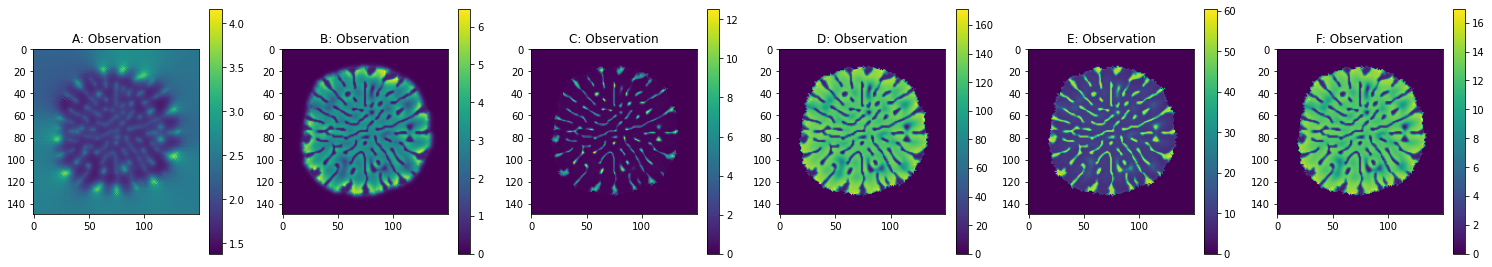

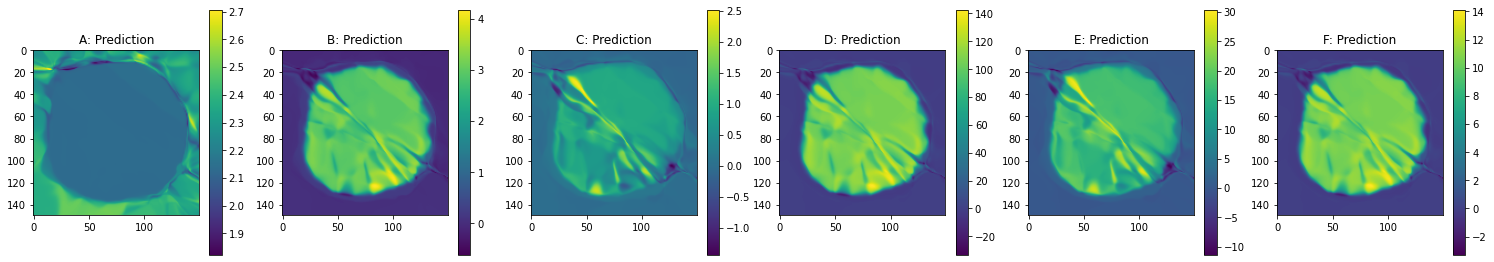

In [81]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [ ]:
results_req = model.train(epochs = 20,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)

In [ ]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
for i in range(output_test.shape[0]):
    output_test[i, :, :, :] = (output_test[i, :, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

In [ ]:
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [ ]:
layers = [3, 64, 64, 64, 64, 6]
pinn2 = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss2 = Circuit2_variant5716(dtype=tf.float64, D_A=df_params.d_A[ID], D_B = df_params.d_B[ID])
model2 = TINN_multi_nodes_masked(pinn2, 
                pde_loss2, 
                nodes_n = nodes_n,
                node_names = node_names,
                alpha = 0.5, 
                print_precision=".8f")

In [ ]:
results2_1 = model2.train(epochs = 50,
                      batch_size = 512*2,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)

In [ ]:
plot_result(merge_dict(results2_1), node_names=node_names, start = 0)

In [ ]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
for i in range(output_test.shape[0]):
    output_test[i, :, :, :] = (output_test[i, :, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

In [ ]:
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [29]:
def plot_result(results, start=0, end=-1, node_names=["u", "v"], yscale="log", y_lims=None):
    import matplotlib.pyplot as plt

    def _closing_commands_():
        plt.legend()
        plt.grid()
        plt.xlabel("Iterations")
        plt.yscale(yscale)
        if y_lims is not None:
            plt.ylim(y_lims)
        plt.show()

    _ = plt.figure(figsize=(14, 5))
    plt.title("Training accuracy for observations")
    plt.plot(results["training_obs_accuracy"][start:end], label="accuracy")
    _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Real Loss")
        plt.plot(results["loss_total"][start:end], label="total")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_obs"][start:end, i], label=f"Obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_pde"][start:end, i], label=f"PDE {name}")
        for key in [k for k in results.keys() if k.startswith("loss_extra_")]:
            plt.plot(results[key][start:end], label=f"{key}")

        _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Regularisd Loss")
        plt.plot(results["loss_regularisd_total"][start:end], label="total")
        if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_obs"][start:end, i] * results[f"loss_obs"][start:end, i],
                    label=f"Obs {name}",
                )
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_pde"][start:end, i] * results[f"loss_pde"][start:end, i],
                    label=f"PDE {name}",
                )
        _closing_commands_()

    if np.any([True if k.startswith("grads_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Gradient Norms")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_obs"][start:end, i], label=f"Grad obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_pde"][start:end, i], label=f"Grad PDE {name}")
        _closing_commands_()

    if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title(r"$\lambda$s")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_obs"][start:end, i], label=r"$\lambda$" f" obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_pde"][start:end, i], label=r"$\lambda$" f" PDE {name}")
        _closing_commands_()
